# ScRNA-Seq of human bone marrow cells from Oetjen et al.

Inspired by the work of [Luecken, MD. et al.](https://www.nature.com/articles/s41592-021-01336-8#Sec35)
<br>Code: https://github.com/theislab/scib-reproducibility/tree/main 
<br>
<br>Data from [Sun, Z. et al.](https://www.nature.com/articles/s41467-019-09639-3)
<br>Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3665018

In [1]:
# Import packages
import scanpy as sc
import pandas as pd
from functions import data_preprocessing as dp

In [2]:
# Path of data
file_base = '../../../../../data/raw/immune_cells/pbmcs_human/GSM3665018_tb_3/'
count_file_end = 'GSM3665018_TB_PBL_matrix.mtx.gz'
gene_data_end = 'GSM3665018_TB_PBL_genes.tsv.gz'
barcode_data_end = 'GSM3665018_TB_PBL_barcodes.tsv.gz'

count_data = file_base+count_file_end
gene_data = file_base+gene_data_end
barcode_data = file_base+barcode_data_end

# Read data
adata = dp.read_sc_data(count_data, gene_data, barcode_data)

adata.var_names_make_unique()

In [3]:
print(adata.X.shape)
print(adata)

(2410, 32738)
AnnData object with n_obs × n_vars = 2410 × 32738
    var: 'gene_id'


In [4]:
adata.var.head()

,gene_id
gene_symbol,
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945


## Metadata from [Sun, Z. et al.](https://www.nature.com/articles/s41467-019-09639-3)

In [5]:
adata.obs["patient"] = "PBMCs_4"
adata.obs["tissue"] = "peripheral blood mononuclear cells"
adata.obs["age"] = "Unknown"
adata.obs["health_condition"] = "healthy"
adata.obs["method"] = "Droplet-based scRNAseq"
adata.obs["instrument"] = "Illumina NextSeq 500"

## Preprocessing

In [6]:
# Add QC metrics to adata
adata = dp.QC().QC_metric_calc(adata)
print(adata.obs)

                    patient                              tissue      age  \
barcode                                                                    
AAACCTGCACAGACTT-1  PBMCs_4  peripheral blood mononuclear cells  Unknown   
AAACCTGCATCGGTTA-1  PBMCs_4  peripheral blood mononuclear cells  Unknown   
AAACCTGTCAAGCCTA-1  PBMCs_4  peripheral blood mononuclear cells  Unknown   
AAACCTGTCTTAACCT-1  PBMCs_4  peripheral blood mononuclear cells  Unknown   
AAACGGGCAATAGCGG-1  PBMCs_4  peripheral blood mononuclear cells  Unknown   
...                     ...                                 ...      ...   
TTTGCGCTCTACGAGT-1  PBMCs_4  peripheral blood mononuclear cells  Unknown   
TTTGGTTAGGAATTAC-1  PBMCs_4  peripheral blood mononuclear cells  Unknown   
TTTGGTTCAGTATAAG-1  PBMCs_4  peripheral blood mononuclear cells  Unknown   
TTTGGTTTCGTAGATC-1  PBMCs_4  peripheral blood mononuclear cells  Unknown   
TTTGTCACAACTTGAC-1  PBMCs_4  peripheral blood mononuclear cells  Unknown   

           

In [7]:
qc_adata = dp.QC().QC_filter_outliers(adata,[5,5,5,5])

Number of cells before QC filtering: 2410
Number of cells removed by log_n_genes filtering: 95
Number of cells removed by log_n_counts filtering: 42
Number of cells removed by pct_counts_in_top_20_genes filtering: 10
Number of cells removed by mt_frac filtering: 65
Number of cells post QC filtering: 2244
Number of genes before filtering: 32738
Number of genes after filtering so theres min 20 unique cells per gene: 10276


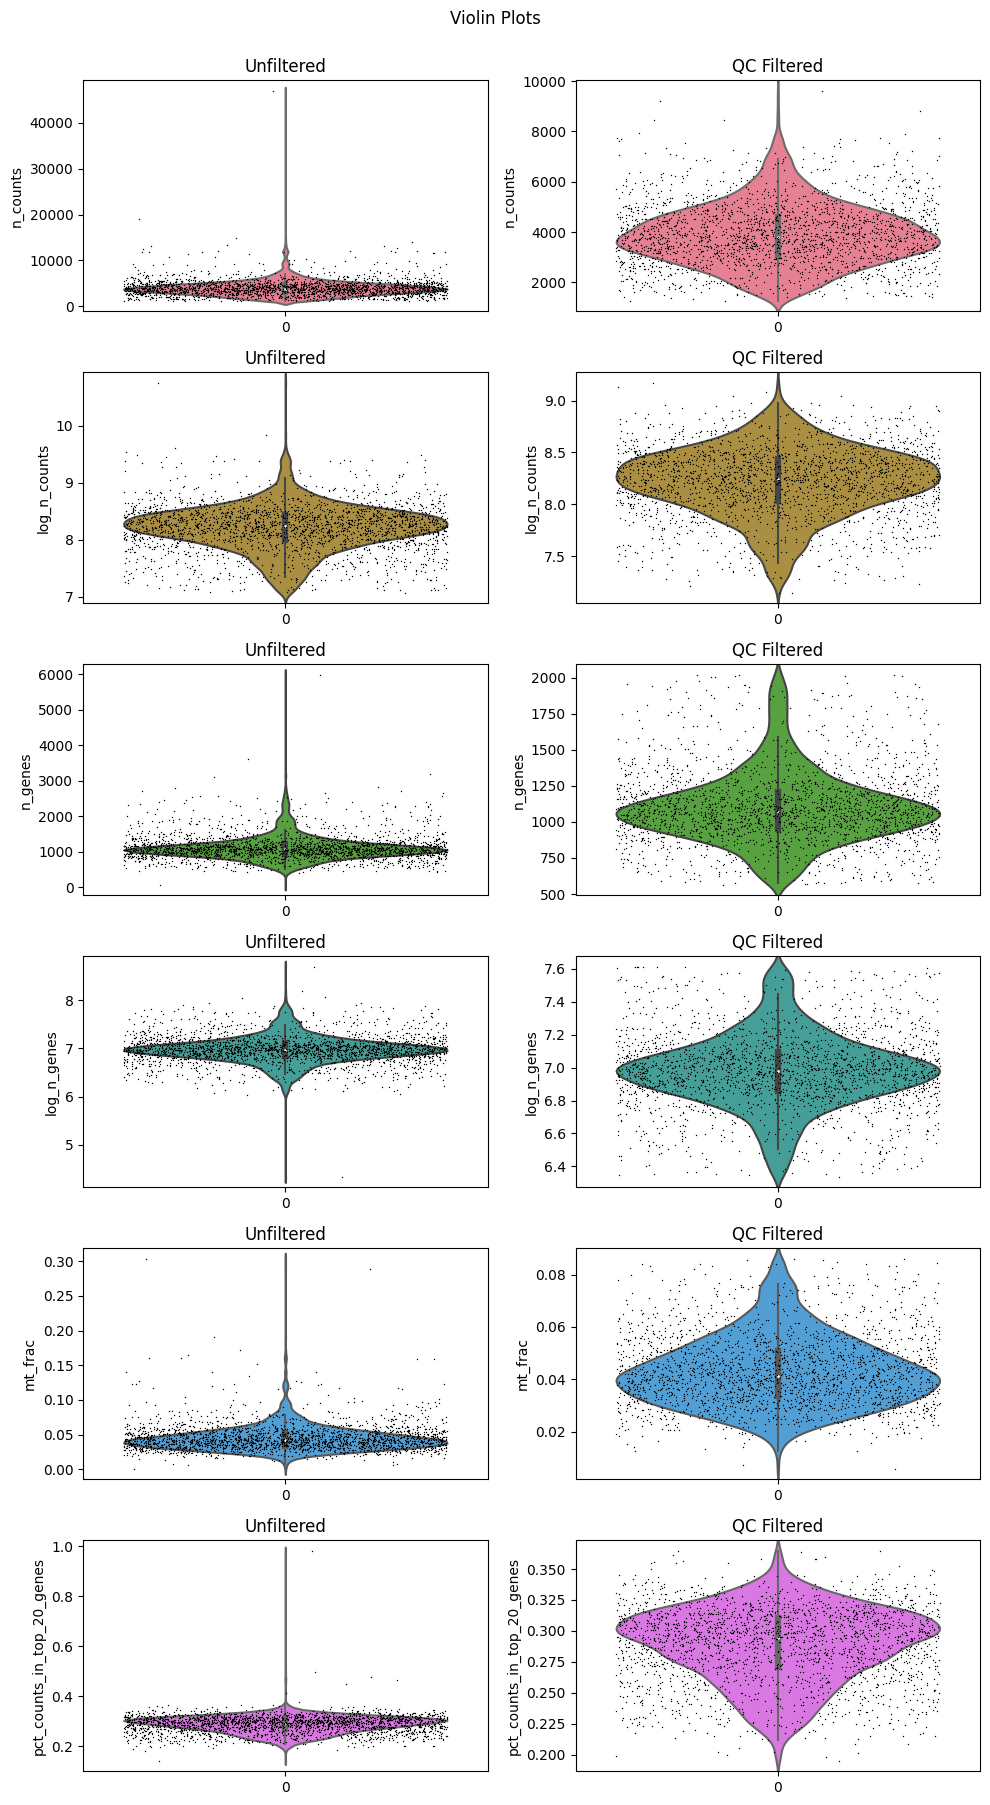

In [8]:
dp.EDA().ViolinJitter([adata, qc_adata], 
                        y_rows=['n_counts','log_n_counts','n_genes','log_n_genes','mt_frac','pct_counts_in_top_20_genes'], 
                        title="Violin Plots",
                        subtitle=["Unfiltered", "QC Filtered"])

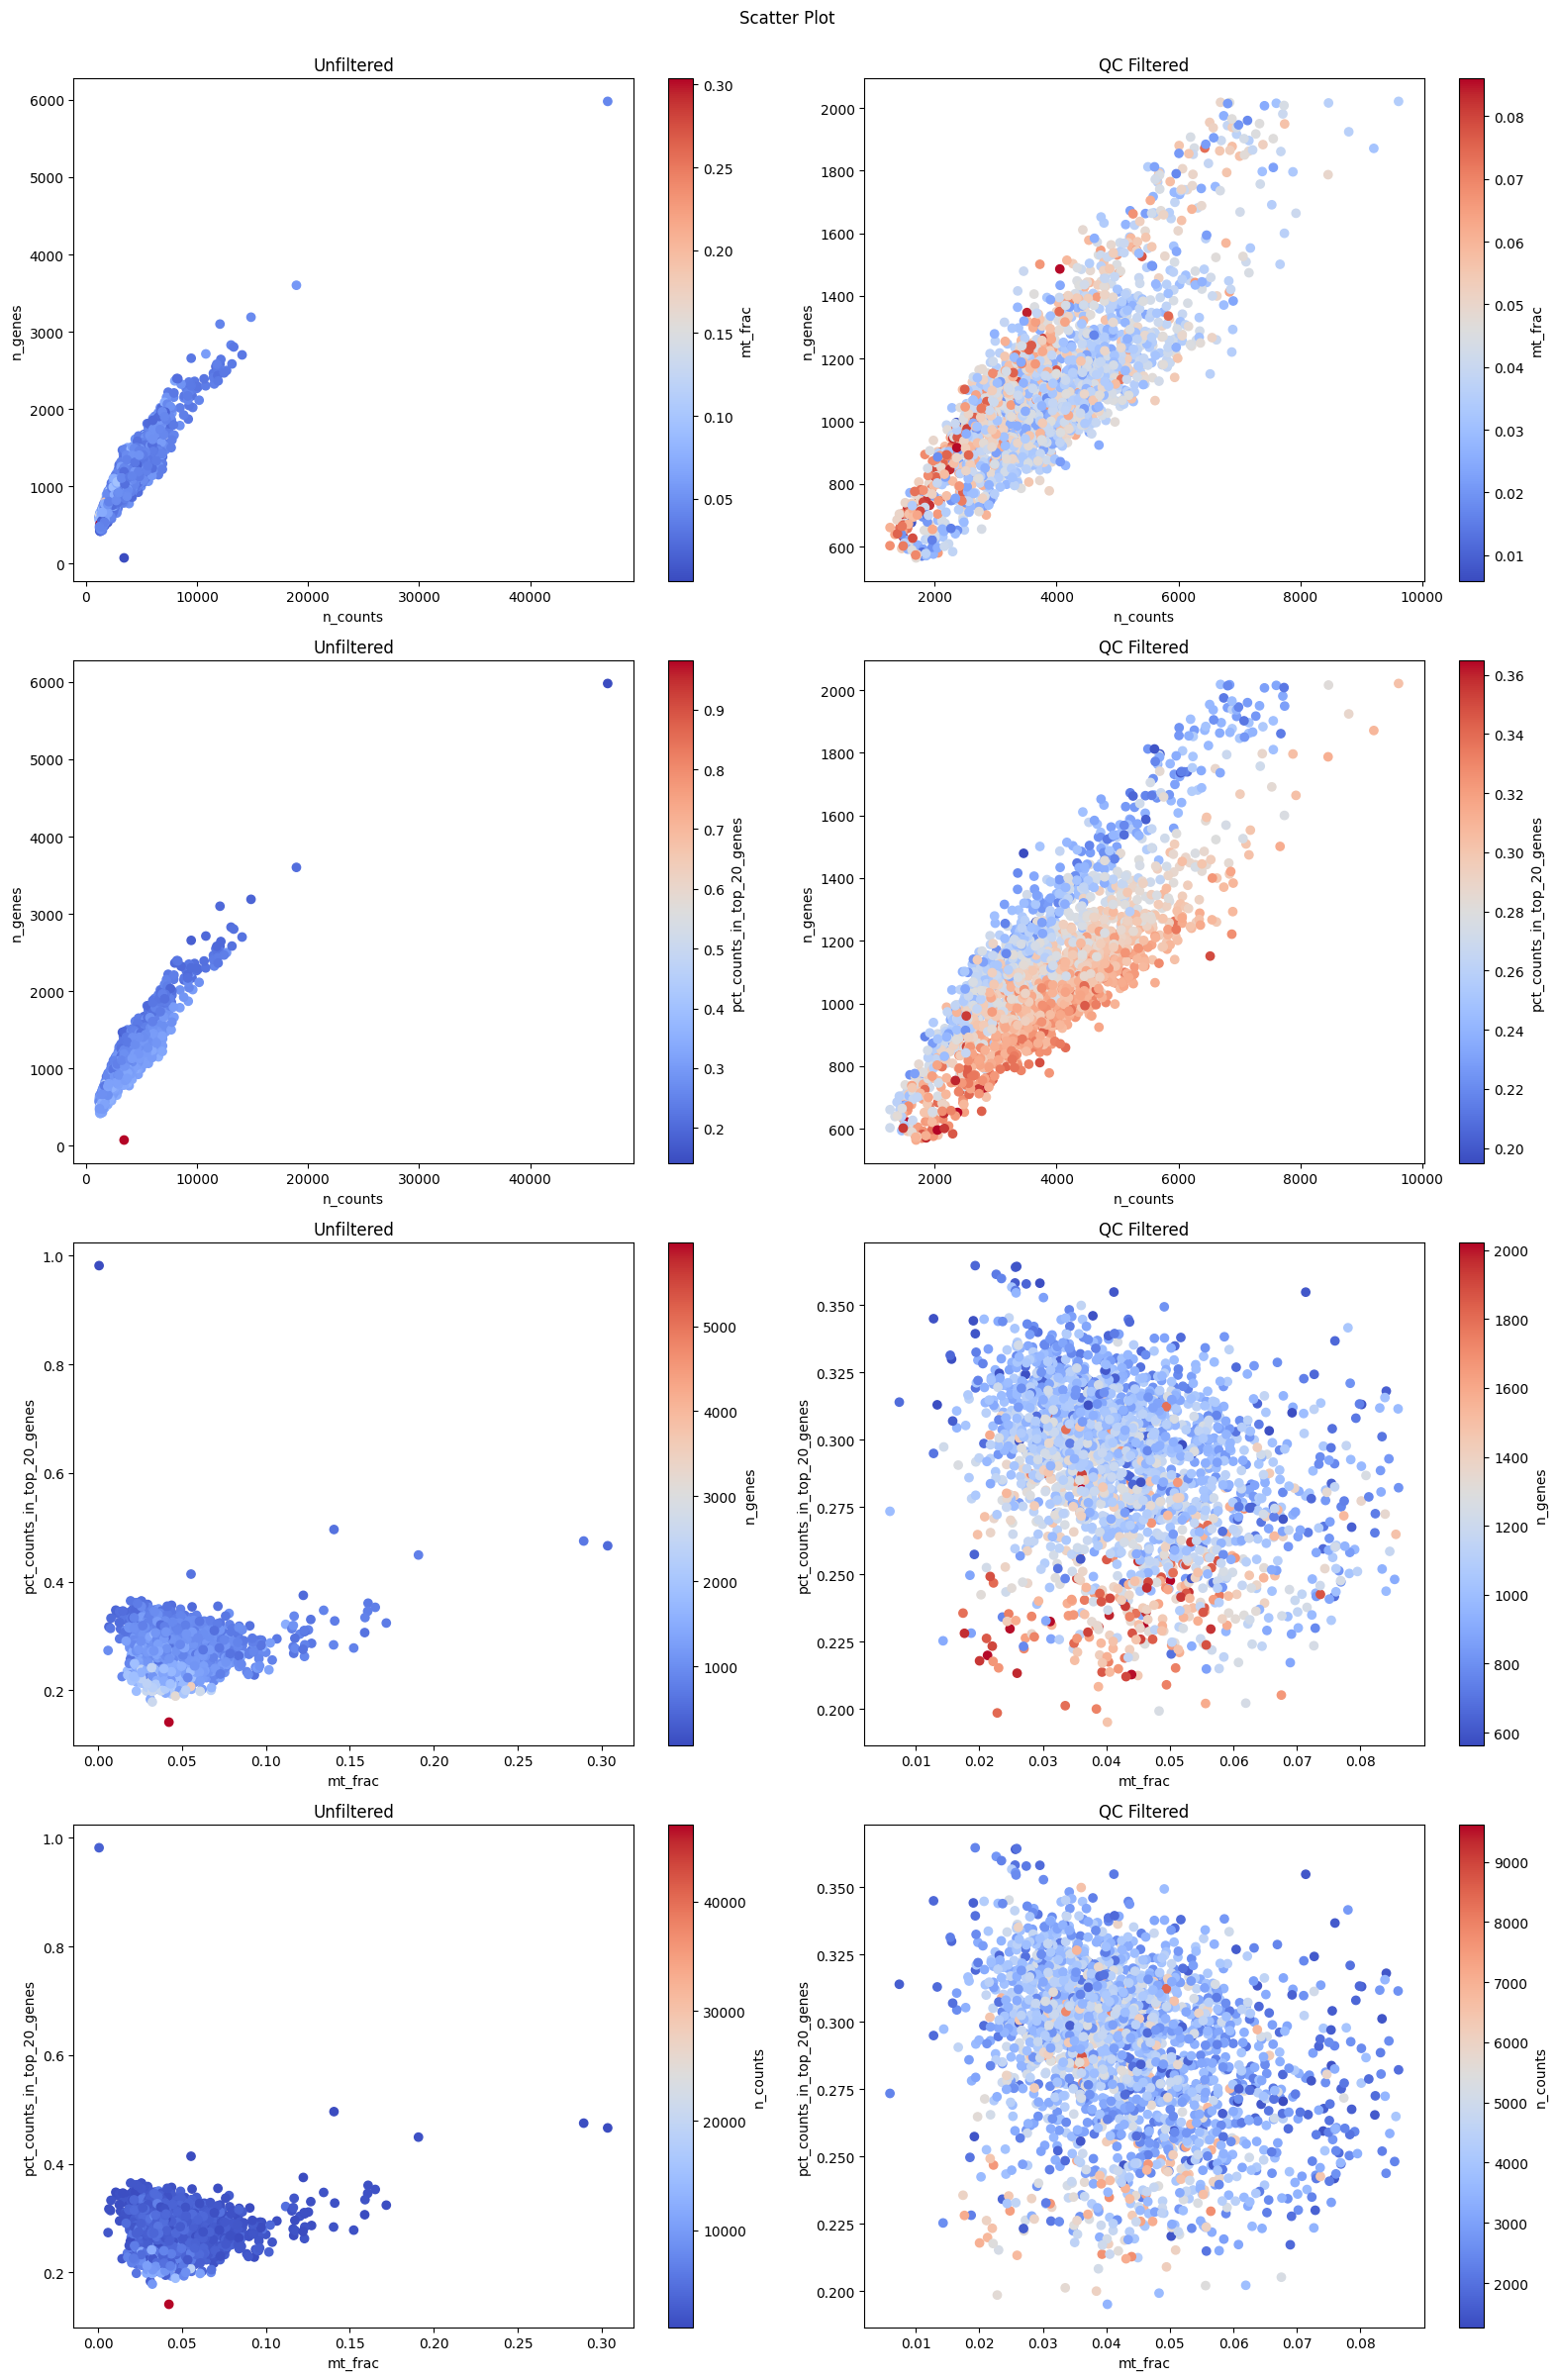

In [9]:
dp.EDA().ScatterForQCMetrics([adata, qc_adata],
                            title="Scatter Plot",
                            subtitle=["Unfiltered", "QC Filtered"])

## Normalize

In [10]:
norm_qc_adata = dp.log1p_normalize(qc_adata)

In [11]:
norm_qc_adata

AnnData object with n_obs × n_vars = 2244 × 10276
    obs: 'patient', 'tissue', 'age', 'health_condition', 'method', 'instrument', 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'outlier', 'size_factors'
    var: 'gene_id', 'n_cells'
    layers: 'counts', 'log1p_counts'

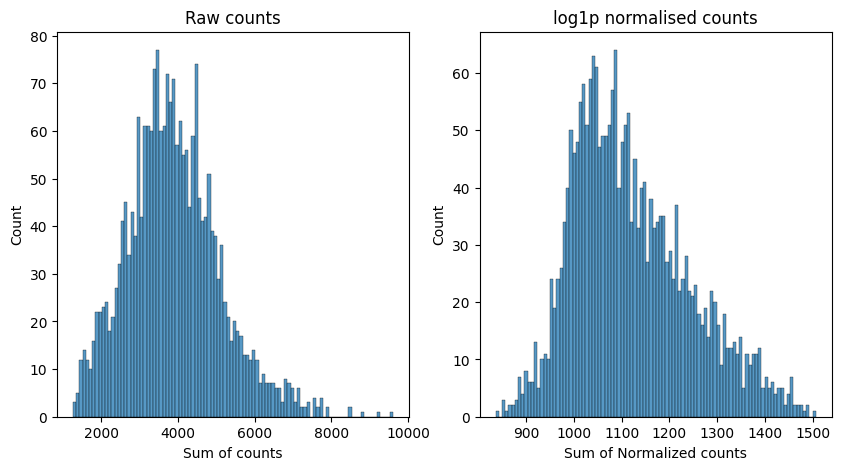

In [12]:
# Visualize counts before and after normalization
dp.EDA().VisualizeNormalization(norm_qc_adata)

In [13]:
# Download normalized count matrix
sc.pp.highly_variable_genes(norm_qc_adata, n_top_genes=4000, flavor="cell_ranger")
HVG_data = norm_qc_adata[:, norm_qc_adata.var["highly_variable"]]
normalized_counts = pd.DataFrame(HVG_data.layers["log1p_counts"])
normalized_counts.index = HVG_data.obs.index.to_list()
normalized_counts.columns = HVG_data.var.index.to_list()
normalized_counts.to_csv("PBMCs_4.csv")
norm_qc_adata.write("PBMCs_4_adata.h5ad")